In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/dataset.zip" -d "/content/drive/MyDrive"

Archive:  /content/drive/MyDrive/dataset.zip
replace /content/drive/MyDrive/dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/__MACOSX/dataset/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/dataset/Training/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/__MACOSX/dataset/Training/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/dataset/Testing/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/__MACOSX/dataset/Testing/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/dataset/Training/pituitary/Tr-pi_0505.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/dataset/Training/pituitary/Tr-pi_0263.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/dataset/Training/pituitary/Tr-pi_0277.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replac

In [ ]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_data_path = "/content/drive/MyDrive/dataset/Training"

filepaths = []
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
  f_path = os.path.join(train_data_path, fold)
  if os.path.isdir(f_path):
    filelists = os.listdir(f_path)

    for file in filelists:
      filepaths.append(os.path.join(f_path, file))
      labels.append(fold)

#Concat data path with labels
Fseries =  pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels , name = 'labels')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [ ]:
train_df

,filepaths,labels
0,/content/drive/MyDrive/dataset/Training/pituit...,pituitary
1,/content/drive/MyDrive/dataset/Training/pituit...,pituitary
2,/content/drive/MyDrive/dataset/Training/pituit...,pituitary
3,/content/drive/MyDrive/dataset/Training/pituit...,pituitary
4,/content/drive/MyDrive/dataset/Training/pituit...,pituitary
...,...,...
5707,/content/drive/MyDrive/dataset/Training/mening...,meningioma
5708,/content/drive/MyDrive/dataset/Training/mening...,meningioma
5709,/content/drive/MyDrive/dataset/Training/mening...,meningioma
5710,/content/drive/MyDrive/dataset/Training/mening...,meningioma


In [ ]:
test_data_path = "/content/drive/MyDrive/dataset/Testing"

filepaths = []
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
  f_path = os.path.join(test_data_path, fold)
  if os.path.isdir(f_path):
    filelists = os.listdir(f_path)

    for file in filelists:
      filepaths.append(os.path.join(f_path, file))
      labels.append(fold)

#Concat data path with labels
Fseries =  pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels , name = 'labels')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [ ]:
test_df

,filepaths,labels
0,/content/drive/MyDrive/dataset/Testing/pituita...,pituitary
1,/content/drive/MyDrive/dataset/Testing/pituita...,pituitary
2,/content/drive/MyDrive/dataset/Testing/pituita...,pituitary
3,/content/drive/MyDrive/dataset/Testing/pituita...,pituitary
4,/content/drive/MyDrive/dataset/Testing/pituita...,pituitary
...,...,...
1306,/content/drive/MyDrive/dataset/Testing/meningi...,meningioma
1307,/content/drive/MyDrive/dataset/Testing/meningi...,meningioma
1308,/content/drive/MyDrive/dataset/Testing/meningi...,meningioma
1309,/content/drive/MyDrive/dataset/Testing/meningi...,meningioma


In [ ]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

# Split train_df into training and validation sets
from sklearn.model_selection import train_test_split
train_df_split, valid_df = train_test_split(train_df, train_size=0.8, random_state=42, stratify=train_df['labels'])

train_gen = tr_gen.flow_from_dataframe(train_df_split , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df , x_col= 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


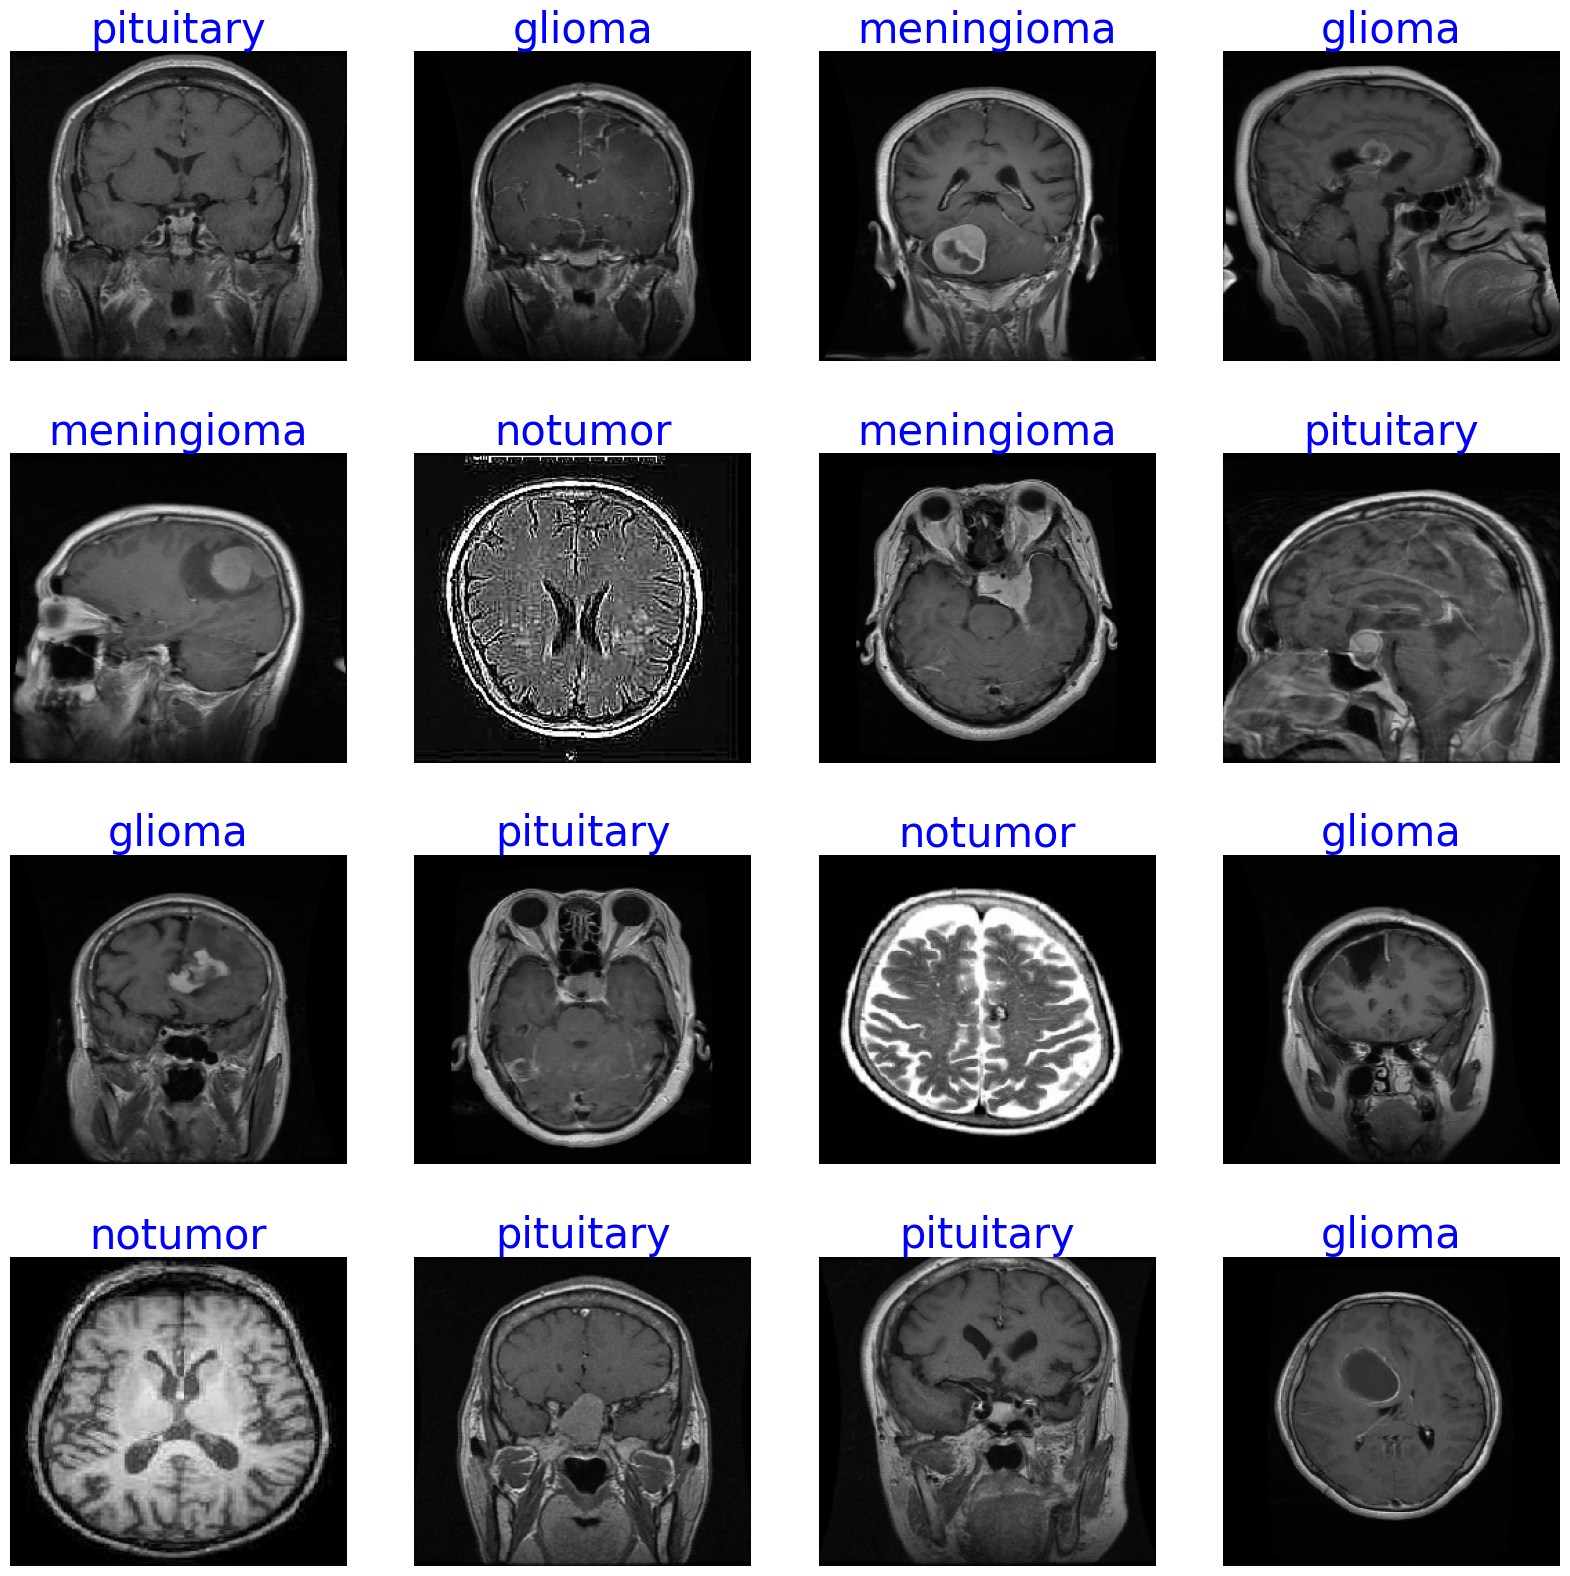

In [ ]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
  plt.subplot(4,4,i+1)
  image = images[i] / 255
  plt.imshow(image)
  index = np.argmax(labels[i])
  class_name = classes[index]
  plt.title(class_name, color = "blue", fontsize = 30)
  plt.axis("off")
plt.show();

In [ ]:
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top = False , weights = 'imagenet',
    input_shape = img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,253,396 (23.85 MB)

 Trainable params: 6,190,228 (23.61 MB)

 Non-trainable params: 63,168 (246.75 KB)

In [ ]:
Epochs = 10

history = model.fit(
    train_gen,
    epochs = Epochs,
    verbose = 1,
    validation_data = valid_gen,
    shuffle = True
)

Epoch 1/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 201s 360ms/step - accuracy: 0.5703 - loss: 11.1469 - val_accuracy: 0.5179 - val_loss: 5.9874
Epoch 2/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 33s 114ms/step - accuracy: 0.3925 - loss: 5.5617 - val_accuracy: 0.4786 - val_loss: 4.3734
Epoch 3/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - accuracy: 0.4386 - loss: 4.0494 - val_accuracy: 0.4689 - val_loss: 3.2053
Epoch 4/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - accuracy: 0.5076 - loss: 2.9423 - val_accuracy: 0.7367 - val_loss: 2.3302
Epoch 5/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - accuracy: 0.6575 - loss: 2.2496 - val_accuracy: 0.7550 - val_loss: 1.7642
Epoch 6/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 32s 111ms/step - accuracy: 0.6973 - loss: 1.7314 - val_accuracy: 0.7699 - val_loss: 1.3360
Epoch 7/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - accuracy: 0.7112 - loss: 1.3906 - val_accuracy: 0.8469 - val_loss: 1.0756
Epoch 8/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - accuracy: 0.8128 - loss:

In [ ]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds , axis = 1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 28s 239ms/step


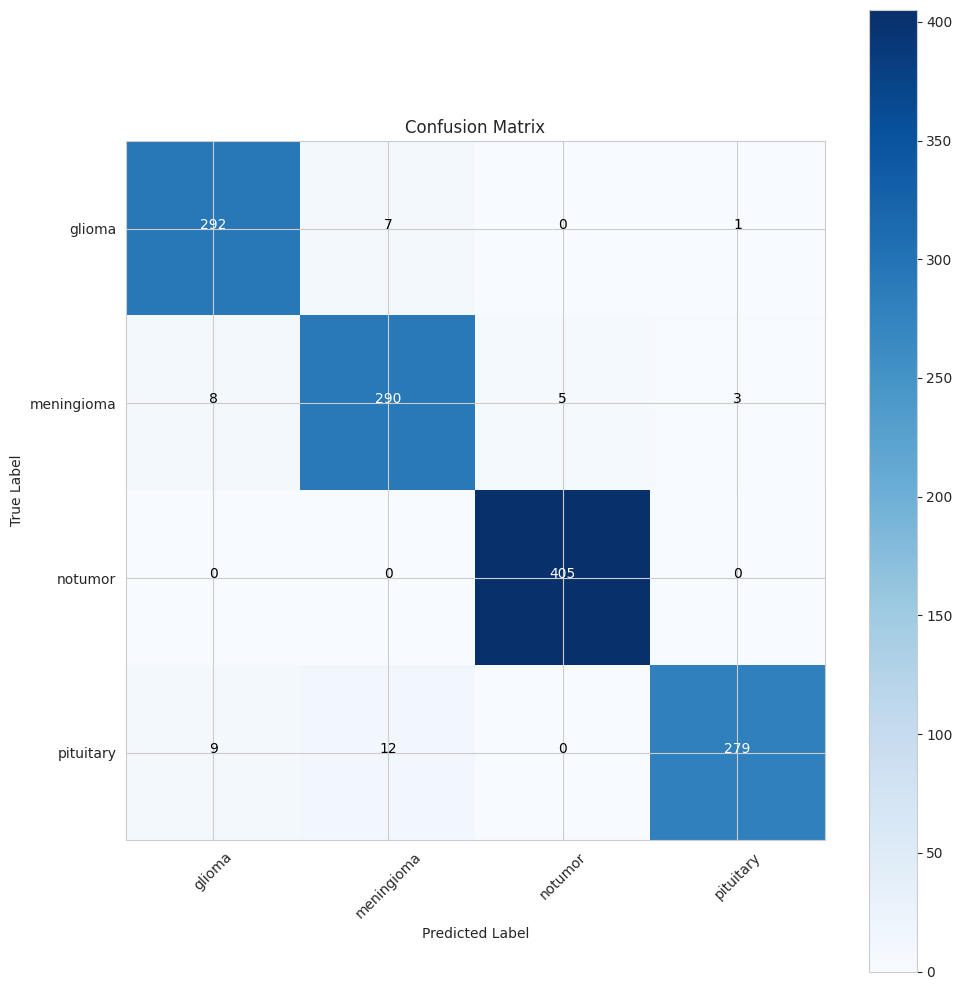

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.94      0.97      0.96       300
  meningioma       0.94      0.95      0.94       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.99      0.93      0.96       300

    accuracy                           0.97      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.97      0.97      0.97      1311



In [ ]:
model.save("model.h5")

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

In [ ]:
model = load_model('model.h5', compile=False)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
gambar = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/dataset/Testing/glioma/Te-glTr_0000.jpg', target_size=img_size)

In [ ]:
input_arr = tf.keras.preprocessing.image.img_to_array(gambar)

In [ ]:
input_arr = np.array([input_arr])
prediksi = model.predict(input_arr)
predicted_class = np.argmax(prediksi, axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step


In [ ]:
print(classes)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
print(predicted_class)

[0]


In [ ]:
names = [classes[i] for i in predicted_class]
print(names)

['glioma']
